# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [127]:
#%pip install wandb

In [1]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [2]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [2]:
wandb.init(project='precursor_charge_prediction_new')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [ ]:
#%pip install seaborn

In [3]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [4]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [5]:
import re
# the dictionary
aa_syntax_dictionary = dict()
for index, i in enumerate(list('XACDEFGHIKLMNPQRSTVWY')): # added X for 0 value
    aa_syntax_dictionary[i] = index * 100
    if i != 'X': # ignore 0 value for X
        for count in range(0, 100):
            aa_syntax_dictionary[i + "[UNIMOD:" + str(count) + "]"] = index * 100 + count

def seq_translator(sequence, dictionary=aa_syntax_dictionary, print_result=False):
    """
    Translates a sequence into a vector of integers
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    if print_result:
        print(result)
    # Fill the list with "X" characters until it reaches a length of 40
    result += ['X'] * (50 - len(result))

    return [dictionary[aa] for aa in result]


def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [6]:
print(seq_translator('AAC[UNIMOD:4]LLVAW', print_result=True))
print(one_hot_precursor(2))

['A', 'A', 'C[UNIMOD:4]', 'L', 'L', 'V', 'A', 'W']
[100, 100, 204, 1000, 1000, 1800, 100, 1900, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0]


In [7]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [8]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 1:
    #    break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [9]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [10]:
batches_parquet[file_list[0]].head()

modified_sequence  precursor_charge  precursor_intensity
0  LPGSLETYVEQEQGENANDR                 2           29525630.0
1       HGSLQEYLQNDTGSK                 2           13188580.0
2        VEEEEEINSELTAR                 2           20663460.0
3  LPGSLETYVEQEQGENANDR                 2           19884630.0
4  NSSTAEINETTTSSTDFLAR                 2           12804420.0

In [11]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [12]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [ ]:
def normalize(df, column):
    """
    Normalizes a column in a dataframe
    :param df: dataframe
    :param column: string
    :return: dataframe
    """
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df

In [63]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [21]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [43]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
    #df_dict[file]["distributions"] = df_dict[file].apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], distributions=True), axis=1)
    # for index, row in df_dict[file].iterrows():
    #     df_dict[file].at[index, "precursor_charge"] = get_most_abundant(row["precursor_charge"], row["precursor_intensity"])
    # df_dict[file]["modified_sequence_vector"] = df_dict[file]["modified_sequence"].apply(seq_translator)
    # df_dict[file]["precursor_charge"] = df_dict[file]["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
    # df_dict[file].rename(columns={"precursor_charge": "most_abundant_charge_vector"}, inplace=True)
    # df_dict[file] = df_dict[file].drop("precursor_intensity", axis=1)
    # df_dict[file] = df_dict[file].drop("modified_sequence", axis=1)

C:\Users\micro\AppData\Local\Temp\ipykernel_15076\2430027825.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_15076\2430027825.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_15076\2430027825.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\A

In [34]:
merged_df = pd.concat(list(df_dict.values())[:-1]).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_15076\3965802802.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())[:-1]).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [64]:
merged_df['normalized'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [46]:
merged_df['pre_normalization'] = merged_df.apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], True), axis=1)

In [66]:
# return key for max value in dict
merged_df['most_abundant_charge'] = merged_df['normalized'].apply(lambda x: max(x, key=x.get))

In [71]:
merged_df["most_abundant_charge_vector"] = merged_df["most_abundant_charge"].apply(one_hot_precursor, args=(charge_ranges,))

In [74]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [75]:
merged_df.head(11)

modified_sequence  \
0       AAAAAAAAAAAAAAAAGLGLGP   
1        AAAAAAAAAAAAAAAASAGGK   
2       AAAAAAAAAAAAAAAGAGAGAK   
3   AAAAAAAAAAAAAAASGFAYPGTSER   
4              AAAAAAAAAAAAAAG   
5            AAAAAAAAAAAAAAGAG   
6       AAAAAAAAAAAAAAGGLALGLH   
7          AAAAAAAAAAAAAAVTSGV   
8             AAAAAAAAAAAAAGAG   
9               AAAAAAAAAAAAAK   
10            AAAAAAAAAAAAHLPS   

                                     precursor_charge  \
0   [2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...   
1       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]   
2                                        [2, 2, 2, 2]   
3   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
4   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
5   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
7   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   
8   [1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...   
9   [1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...   
10  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...   

                                  precursor_intensity  \
0   [12746190.0, 2009914.0, 12746190.0, 791369.9, ...   
1   [5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...   
2        [3067981.0, 3067981.0, 3067981.0, 3067981.0]   
3   [11913300.0, 11913300.0, 11913300.0, 11913300....   
4   [1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...   
5   [853119.3, 4332449.0, 3688977.0, 3469130.0, 33...   
6   [33516080.0, 33516080.0, 8522070.0, 4549188.0,...   
7   [4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...   
8   [1233316.0, 2671238.0, 11414430.0, 13683660.0,...   
9   [2540360.0, 31115000.0, 31115000.0, 70371250.0...   
10  [27030420.0, 22099630.0, 71770480.0, 22099630....   

                                  normalized  \
0   {2: 588796.3, 3: 4654280.0, 1: 791369.9}   
1                              {2: 303307.5}   
2                             {2: 3067981.0}   
3               {2: 8093413.0, 3: 1414907.0}   
4                             {1: 1124818.0}   
5                              {1: 679216.3}   
6                              {2: 365943.3}   
7              {2: 14611910.0, 1: 1211272.0}   
8               {1: 1879604.0, 2: 2586197.0}   
9              {1: 8372130.0, 2: 15308280.0}   
10                            {2: 5810305.0}   

                                 pre_normalization  most_abundant_charge  \
0   {2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}                     3   
1                                 {2: 107202221.5}                     2   
2                                  {2: 12271924.0}                     2   
3                   {2: 148659685.0, 3: 4244721.0}                     2   
4                           {1: 546950229.4000001}                     1   
5                                  {1: 52634067.9}                     1   
6                           {2: 6848110396.300002}                     2   
7            {2: 225462597.40000004, 1: 5840742.2}                     2   
8                 {1: 349665943.5, 2: 228379326.3}                     2   
9                 {1: 99493666.2, 2: 6574531120.0}                     2   
10                               {2: 9446767331.0}                     2   

   most_abundant_charge_vector  \
0           [0, 0, 1, 0, 0, 0]   
1           [0, 1, 0, 0, 0, 0]   
2           [0, 1, 0, 0, 0, 0]   
3           [0, 1, 0, 0, 0, 0]   
4           [1, 0, 0, 0, 0, 0]   
5           [1, 0, 0, 0, 0, 0]   
6           [0, 1, 0, 0, 0, 0]   
7           [0, 1, 0, 0, 0, 0]   
8           [0, 1, 0, 0, 0, 0]   
9           [0, 1, 0, 0, 0, 0]   
10          [0, 1, 0, 0, 0, 0]   

                             modified_sequence_vector  
0   [100, 100, 100, 100, 100, 100, 100, 100, 100, ...  
1   [100, 100, 100, 100, 100, 100, 100, 100, 100, ...  
2   [100, 100, 100, 100, 100, 100, 100, 100, 100, ...  
3   [100, 100, 100, 100, 100, 100, 100, 100, 100, ...  
4   [100, 100, 100, 100, 100, 100, 100, 100, 100, ...  

# Dataset preprocessing

In [12]:
# import numpy as np
# # Find most frequent precursor charge
# def most_frequent(List):
#     unique, counts = np.unique(List, return_counts=True)
#     index = np.argmax(counts)
#     return unique[index]

In [68]:
# proof of concept
# we have a sequence ABC with:
list_a = [1,2,1,2,1,2,1,2,1,2] # charge states for "ABC" sequence with multiple appearances
list_b = [111,21,311,41,51,611111,71,81,91111111,1011] # intensities for "ABC" sequence in each charge state
print("most abundant: ", get_most_abundant(list_a, list_b, True))

most abundant:  {1: 91111655, 2: 612265}


In [16]:
# # Grouping by "modified_sequence" and aggregating precursor_charge into a list
# grouped_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
#
# for index, row in grouped_df.iterrows():
#     grouped_df.at[index, "precursor_charge"] = get_most_abundant(row["precursor_charge"], row["precursor_intensity"])
# grouped_df["modified_sequence_vector"] = grouped_df["modified_sequence"].apply(seq_translator)
# grouped_df["precursor_charge"] = grouped_df["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
# grouped_df.rename(columns={"precursor_charge": "most_abundant_charge_vector"}, inplace=True)
# grouped_df = grouped_df.drop("precursor_intensity", axis=1)
# grouped_df = grouped_df.drop("modified_sequence", axis=1)
# grouped_df

C:\Users\micro\AppData\Local\Temp\ipykernel_1096\3742099937.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


most_abundant_charge_vector  \
0              [0, 1, 0, 0, 0, 0]   
1              [0, 1, 0, 0, 0, 0]   
2              [0, 1, 0, 0, 0, 0]   
3              [0, 1, 0, 0, 0, 0]   
4              [0, 0, 1, 0, 0, 0]   
...                           ...   
70440          [0, 1, 0, 0, 0, 0]   
70441          [0, 1, 0, 0, 0, 0]   
70442          [0, 0, 1, 0, 0, 0]   
70443          [0, 1, 0, 0, 0, 0]   
70444          [0, 1, 0, 0, 0, 0]   

                                modified_sequence_vector  
0      [100, 100, 100, 100, 1600, 100, 100, 400, 100,...  
1      [100, 100, 100, 204, 500, 500, 400, 1400, 1300...  
2      [100, 100, 100, 300, 500, 100, 1700, 700, 600,...  
3      [100, 100, 100, 300, 1000, 1100, 100, 2000, 20...  
4      [100, 100, 100, 300, 1600, 300, 1300, 1200, 10...  
...                                                  ...  
70440  [2000, 2000, 1800, 2000, 1900, 2000, 1400, 140...  
70441  [2000, 2000, 2000, 400, 1200, 1600, 300, 1400,...  
70442  [2000, 2000, 2000, 600, 700, 2000, 1000, 300, ...  
70443  [2000, 2000, 2000, 1600, 300, 1200, 500, 500, ...  
70444  [2000, 2000, 2000, 1800, 1300, 100, 300, 500, ...  

[70445 rows x 2 columns]

In [76]:
main_ds = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels = np.array(merged_df['most_abundant_charge_vector'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies, val_indicies = next(sss.split(main_ds, main_ds_labels))
train_ds, train_ds_labels = main_ds[train_indicies], main_ds_labels[train_indicies]
val_ds, val_ds_labels = main_ds[val_indicies], main_ds_labels[val_indicies]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)


### Model

In [19]:
train_ds = [np.reshape(np.array(x), (1, 50, 1)) for x in train_ds]
val_ds = [np.reshape(np.array(x), (1, 50, 1)) for x in val_ds]

In [19]:
train_ds[0]

array([[[ 300],
        [2000],
        [ 800],
        [1200],
        [ 600],
        [1600],
        [1000],
        [1000],
        [ 400],
        [ 100],
        [1000],
        [ 900],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]]])

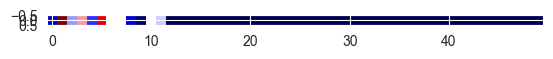

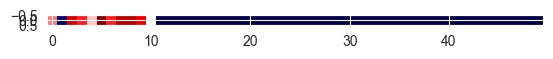

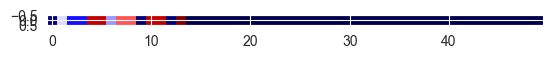

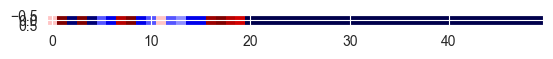

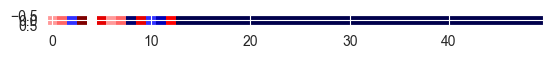

In [20]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_ds[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [21]:
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

In [22]:
train_ds_labels = [np.array(x) for x in train_ds_labels]
val_ds_labels = [np.array(x) for x in val_ds_labels]

In [23]:
train_ds_labels = tf.convert_to_tensor(train_ds_labels)
val_ds_labels = tf.convert_to_tensor(val_ds_labels)

In [26]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=train_ds.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./100)(inputA) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(210, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input], outputs=z)

In [27]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 50, 1)]        0         
                                                                 
 rescaling_1 (Rescaling)     (None, 1, 50, 1)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 50, 128)        512       
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 210)               1344210   
                                                                 
 dense_2 (Dense)             (None, 6)                 1266      
                                                                 
Total params: 1,345,988
Trainable params: 1,345,988
Non-tra

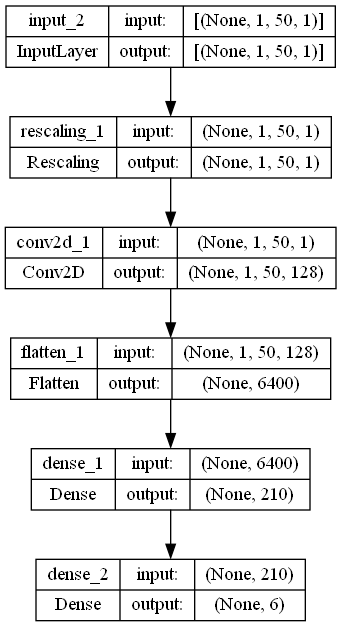

In [28]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [30]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [32]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit(train_ds, train_ds_labels, epochs=120, batch_size=4096, validation_data=(val_ds, val_ds_labels), callbacks=[checkpoint_callback, early_stopping, WandbCallback()]) #WandbCallback()

Epoch 1/120
14/14 [==============================] - 2s 116ms/step - loss: 0.5786 - accuracy: 0.7314 - val_loss: 0.5991 - val_accuracy: 0.7172
Epoch 2/120
14/14 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.7315

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 174ms/step - loss: 0.5781 - accuracy: 0.7315 - val_loss: 0.5980 - val_accuracy: 0.7165
Epoch 3/120
14/14 [==============================] - 2s 111ms/step - loss: 0.5771 - accuracy: 0.7321 - val_loss: 0.5983 - val_accuracy: 0.7190
Epoch 4/120
14/14 [==============================] - 2s 116ms/step - loss: 0.5764 - accuracy: 0.7332 - val_loss: 0.5984 - val_accuracy: 0.7194
Epoch 5/120
14/14 [==============================] - 2s 116ms/step - loss: 0.5761 - accuracy: 0.7321 - val_loss: 0.6012 - val_accuracy: 0.7194
Epoch 6/120
14/14 [==============================] - ETA: 0s - loss: 0.5755 - accuracy: 0.7331

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 179ms/step - loss: 0.5755 - accuracy: 0.7331 - val_loss: 0.5972 - val_accuracy: 0.7177
Epoch 7/120
14/14 [==============================] - 2s 120ms/step - loss: 0.5746 - accuracy: 0.7332 - val_loss: 0.5974 - val_accuracy: 0.7204
Epoch 8/120
14/14 [==============================] - 2s 115ms/step - loss: 0.5739 - accuracy: 0.7333 - val_loss: 0.5976 - val_accuracy: 0.7213
Epoch 9/120
14/14 [==============================] - 2s 111ms/step - loss: 0.5734 - accuracy: 0.7337 - val_loss: 0.5975 - val_accuracy: 0.7192
Epoch 10/120
14/14 [==============================] - 2s 121ms/step - loss: 0.5726 - accuracy: 0.7347 - val_loss: 0.5972 - val_accuracy: 0.7221
Epoch 11/120
14/14 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7344

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.1s


14/14 [==============================] - 3s 212ms/step - loss: 0.5720 - accuracy: 0.7344 - val_loss: 0.5968 - val_accuracy: 0.7213
Epoch 12/120
14/14 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7354

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 175ms/step - loss: 0.5711 - accuracy: 0.7354 - val_loss: 0.5964 - val_accuracy: 0.7204
Epoch 13/120
14/14 [==============================] - 2s 110ms/step - loss: 0.5705 - accuracy: 0.7354 - val_loss: 0.5973 - val_accuracy: 0.7220
Epoch 14/120
14/14 [==============================] - 2s 116ms/step - loss: 0.5717 - accuracy: 0.7335 - val_loss: 0.5966 - val_accuracy: 0.7223
Epoch 15/120
14/14 [==============================] - 2s 112ms/step - loss: 0.5710 - accuracy: 0.7348 - val_loss: 0.5969 - val_accuracy: 0.7198
Epoch 16/120
14/14 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.7354

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 179ms/step - loss: 0.5692 - accuracy: 0.7354 - val_loss: 0.5963 - val_accuracy: 0.7202
Epoch 17/120
14/14 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.7361

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 175ms/step - loss: 0.5702 - accuracy: 0.7361 - val_loss: 0.5963 - val_accuracy: 0.7196
Epoch 18/120
14/14 [==============================] - 2s 110ms/step - loss: 0.5711 - accuracy: 0.7355 - val_loss: 0.5976 - val_accuracy: 0.7213
Epoch 19/120
14/14 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.7362

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 182ms/step - loss: 0.5681 - accuracy: 0.7362 - val_loss: 0.5962 - val_accuracy: 0.7201
Epoch 20/120
14/14 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7358

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 170ms/step - loss: 0.5671 - accuracy: 0.7358 - val_loss: 0.5959 - val_accuracy: 0.7199
Epoch 21/120
14/14 [==============================] - ETA: 0s - loss: 0.5661 - accuracy: 0.7370

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.1s


14/14 [==============================] - 2s 178ms/step - loss: 0.5661 - accuracy: 0.7370 - val_loss: 0.5959 - val_accuracy: 0.7201
Epoch 22/120
14/14 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7370

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 171ms/step - loss: 0.5667 - accuracy: 0.7370 - val_loss: 0.5957 - val_accuracy: 0.7206
Epoch 23/120
14/14 [==============================] - 2s 113ms/step - loss: 0.5659 - accuracy: 0.7377 - val_loss: 0.5967 - val_accuracy: 0.7215
Epoch 24/120
14/14 [==============================] - 2s 114ms/step - loss: 0.5650 - accuracy: 0.7383 - val_loss: 0.5965 - val_accuracy: 0.7211
Epoch 25/120
14/14 [==============================] - 2s 113ms/step - loss: 0.5648 - accuracy: 0.7381 - val_loss: 0.5962 - val_accuracy: 0.7196
Epoch 26/120
14/14 [==============================] - 2s 116ms/step - loss: 0.5640 - accuracy: 0.7388 - val_loss: 0.5966 - val_accuracy: 0.7192
Epoch 27/120
14/14 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.7395

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230803_125300-645xp3wf\files\model-best)... Done. 0.0s


14/14 [==============================] - 2s 176ms/step - loss: 0.5632 - accuracy: 0.7395 - val_loss: 0.5955 - val_accuracy: 0.7200
Epoch 28/120
14/14 [==============================] - 2s 115ms/step - loss: 0.5628 - accuracy: 0.7400 - val_loss: 0.5959 - val_accuracy: 0.7208
Epoch 29/120
14/14 [==============================] - 2s 112ms/step - loss: 0.5622 - accuracy: 0.7400 - val_loss: 0.5956 - val_accuracy: 0.7199
Epoch 30/120
14/14 [==============================] - 2s 112ms/step - loss: 0.5617 - accuracy: 0.7399 - val_loss: 0.5974 - val_accuracy: 0.7212
Epoch 31/120
14/14 [==============================] - 2s 122ms/step - loss: 0.5618 - accuracy: 0.7411 - val_loss: 0.5958 - val_accuracy: 0.7213
Epoch 32/120
14/14 [==============================] - 2s 114ms/step - loss: 0.5601 - accuracy: 0.7413 - val_loss: 0.5963 - val_accuracy: 0.7204


In [ ]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Embedding model test:

In [77]:
main_ds_embed = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels_embed = np.array(merged_df['most_abundant_charge_vector'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_indicies_embed, val_indicies_embed = next(sss.split(main_ds_embed, main_ds_labels_embed))
train_ds_embed, train_ds_labels_embed = main_ds_embed[train_indicies_embed], main_ds_labels_embed[train_indicies]
val_ds_embed, val_ds_labels_embed = main_ds_embed[val_indicies_embed], main_ds_labels_embed[val_indicies_embed]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)


In [78]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]

In [79]:
train_ds_labels_embed = [np.array(x) for x in train_ds_labels_embed]
val_ds_labels_embed = [np.array(x) for x in val_ds_labels_embed]

In [80]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_ds_labels_embed = tf.convert_to_tensor(train_ds_labels_embed)
val_ds_labels_embed = tf.convert_to_tensor(val_ds_labels_embed)

In [81]:
train_ds_embed[0]

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([ 500,  600, 1700, 1400, 1000, 1000, 2000,  900,  500,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>

In [87]:
wandb.init(project='precursor_charge_prediction_new')

In [99]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
# the first branch operates on the first input
x = Model(inputs=inputA_embed, outputs=inputA_embed)
# the second branch operates on the second input
# input = sequence mit shape (50, 1)
y = Embedding(input_dim=8000, output_dim=50, input_length=50)(inputA_embed)
# output = ???? 8000x50x50
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(64, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model_embed = Model(inputs=[x.input], outputs=z)

In [95]:
model_embed.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 150)           2400000   
                                                                 
 flatten_2 (Flatten)         (None, 7500)              0         
                                                                 
 dense_4 (Dense)             (None, 120)               900120    
                                                                 
 dense_5 (Dense)             (None, 6)                 726       
                                                                 
Total params: 3,300,846
Trainable params: 3,300,846
Non-trainable params: 0
_________________________________________________________________


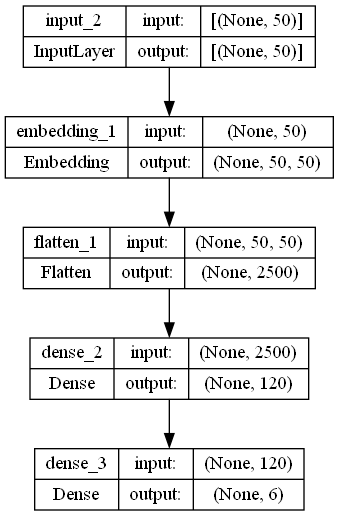

In [90]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [96]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [97]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [98]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_ds_labels_embed, epochs=150, batch_size=4096, validation_data=(val_ds_embed, val_ds_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()]) #WandbCallback()

Epoch 1/150
162/162 [==============================] - 16s 98ms/step - loss: 1.0340 - categorical_accuracy: 0.5911 - val_loss: 0.8886 - val_categorical_accuracy: 0.6275
Epoch 2/150
162/162 [==============================] - 16s 96ms/step - loss: 0.8116 - categorical_accuracy: 0.6618 - val_loss: 0.7332 - val_categorical_accuracy: 0.6943
Epoch 3/150
162/162 [==============================] - 15s 93ms/step - loss: 0.6696 - categorical_accuracy: 0.7158 - val_loss: 0.6155 - val_categorical_accuracy: 0.7336
Epoch 4/150
162/162 [==============================] - 15s 92ms/step - loss: 0.5841 - categorical_accuracy: 0.7538 - val_loss: 0.5585 - val_categorical_accuracy: 0.7659
Epoch 5/150
162/162 [==============================] - 15s 91ms/step - loss: 0.5452 - categorical_accuracy: 0.7708 - val_loss: 0.5345 - val_categorical_accuracy: 0.7760
Epoch 6/150
162/162 [==============================] - 15s 92ms/step - loss: 0.5269 - categorical_accuracy: 0.7777 - val_loss: 0.5218 - val_categorical_acc

KeyboardInterrupt: 

In [34]:
model_embed.save('precursor_charge_prediction_model_embed/history_embed_150epoch.h5')

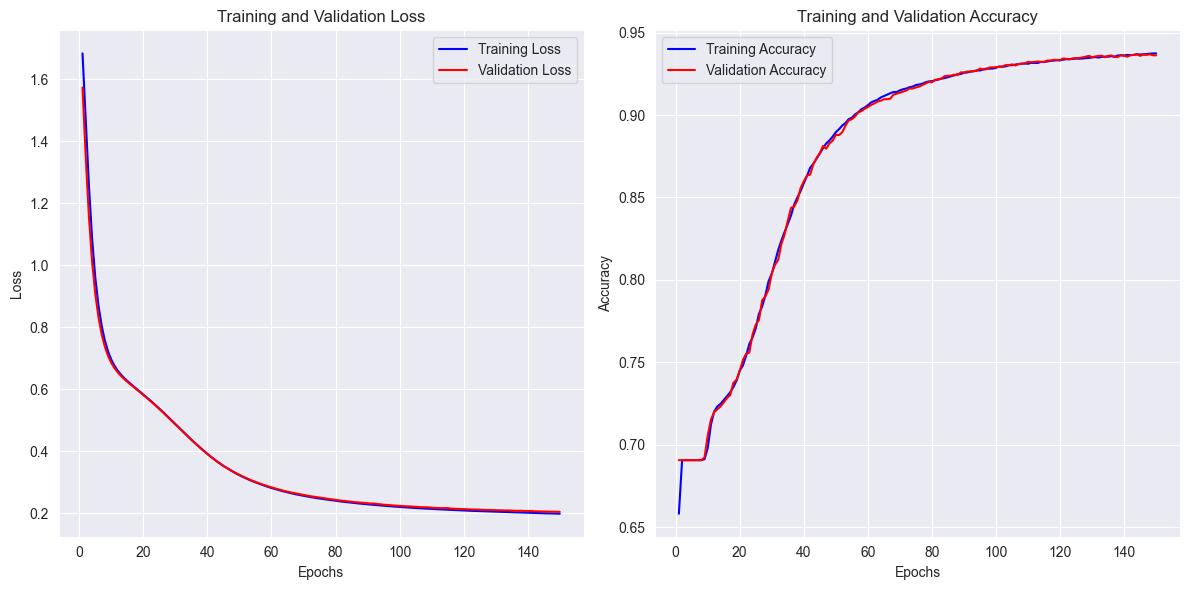

In [37]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
accuracy = history_embed.history['categorical_accuracy']
val_accuracy = history_embed.history['val_categorical_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Inference

In [41]:
file_list[1]

'data/TUM_aspn_meta_data.parquet'

In [52]:
batches_parquet[file_list[1]].head()

modified_sequence  precursor_charge  precursor_intensity
0  DSVGEITKEDLIQKSLGTC[UNIMOD:4]Q                 2            7552496.0
1  DSVGEITKEDLIQKSLGTC[UNIMOD:4]Q                 2            7674974.0
2  DSVGEITKEDLIQKSLGTC[UNIMOD:4]Q                 2            3298128.0
3  DSVGEITKEDLIQKSLGTC[UNIMOD:4]Q                 2            1224600.0
4  DSVGEITKEDLIQKSLGTC[UNIMOD:4]Q                 2            3298128.0

In [54]:
# Grouping by "modified_sequence" and aggregating precursor_charge into a list
grouped_df_embed = batches_parquet[file_list[1]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

for index, row in grouped_df_embed.iterrows():
    grouped_df_embed.at[index, "precursor_charge"] = get_most_abundant(row["precursor_charge"], row["precursor_intensity"])

grouped_df_embed["modified_sequence_vector"] = grouped_df_embed["modified_sequence"].apply(seq_translator)
grouped_df_embed["precursor_charge"] = grouped_df_embed["precursor_charge"].apply(one_hot_precursor, args=(charge_ranges,))
grouped_df_embed.rename(columns={"precursor_charge": "most_abundant_charge_vector"}, inplace=True)
grouped_df_embed = grouped_df_embed.drop("precursor_intensity", axis=1)
grouped_df_embed = grouped_df_embed.drop("modified_sequence", axis=1)
grouped_df_embed

C:\Users\micro\AppData\Local\Temp\ipykernel_1096\984353119.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df_embed = batches_parquet[file_list[1]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


most_abundant_charge_vector  \
0              [1, 0, 0, 0, 0, 0]   
1              [0, 1, 0, 0, 0, 0]   
2              [0, 1, 0, 0, 0, 0]   
3              [0, 0, 1, 0, 0, 0]   
4              [0, 1, 0, 0, 0, 0]   
...                           ...   
33727          [0, 0, 1, 0, 0, 0]   
33728          [0, 0, 1, 0, 0, 0]   
33729          [0, 1, 0, 0, 0, 0]   
33730          [0, 1, 0, 0, 0, 0]   
33731          [0, 1, 0, 0, 0, 0]   

                                modified_sequence_vector  
0      [300, 100, 100, 100, 100, 100, 100, 100, 1300,...  
1      [300, 100, 100, 100, 100, 600, 300, 1700, 1000...  
2      [300, 100, 100, 100, 100, 1000, 1600, 1800, 10...  
3      [300, 100, 100, 100, 100, 1000, 1600, 1800, 10...  
4      [300, 100, 100, 100, 100, 1300, 100, 1700, 130...  
...                                                  ...  
33727  [300, 2000, 2000, 1600, 700, 1000, 900, 900, 4...  
33728  [300, 2000, 2000, 1600, 1600, 1500, 1600, 1400...  
33729  [300, 2000, 2000, 1800, 600, 900, 900, 1200, 8...  
33730  [300, 2000, 2000, 1800, 600, 900, 900, 1200, 8...  
33731  [300, 2000, 2000, 1800, 700, 1000, 800, 100, 0...  

[33732 rows x 2 columns]

In [68]:
grouped_df_embed['modified_sequence_vector'] = grouped_df_embed['modified_sequence_vector'].apply(lambda x: np.array(x))

In [107]:
# size of df
grouped_df_embed.shape

(33732, 2)

In [ ]:
# ValueError: Layer "model_1" expects 1 input(s), but it received 33732 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 50) dtype=int32>, <tf.Tensor

In [131]:
# solut = [np.expand_dims(tf.convert_to_tensor(np.array(x)), axis=0) for x in grouped_df_embed["modified_sequence_vector"]]
# predictions = model_embed.predict(solut, batch_size=4096, verbose=True)

ValueError: in user code:

    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\micro\OneDrive\Dokumente\GitHub\BachelorThesis\venv\Lib\site-packages\keras\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 1 input(s), but it received 33732 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:1999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:2999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:3999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:4999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:5999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:6999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:7999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:8999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:9999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:10999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:11999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:12999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:13999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:14999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:15999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:16999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:17999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:18999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:19999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:20999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:21999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:22999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:23999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:24999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:25999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:26999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:27999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:28999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:29999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:30999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:31999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32731' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32732' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32733' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32734' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32735' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32736' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32737' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32738' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32739' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32740' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32741' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32742' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32743' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32744' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32745' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32746' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32747' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32748' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32749' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32750' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32751' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32752' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32753' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32754' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32755' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32756' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32757' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32758' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32759' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32760' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32761' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32762' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32763' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32764' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32765' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32766' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32767' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32768' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32769' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32770' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32771' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32772' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32773' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32774' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32775' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32776' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32777' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32778' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32779' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32780' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32781' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32782' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32783' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32784' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32785' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32786' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32787' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32788' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32789' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32790' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32791' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32792' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32793' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32794' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32795' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32796' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32797' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32798' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32799' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32800' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32801' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32802' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32803' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32804' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32805' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32806' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32807' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32808' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32809' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32810' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32811' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32812' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32813' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32814' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32815' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32816' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32817' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32818' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32819' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32820' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32821' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32822' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32823' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32824' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32825' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32826' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32827' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32828' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32829' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32830' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32831' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32832' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32833' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32834' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32835' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32836' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32837' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32838' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32839' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32840' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32841' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32842' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32843' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32844' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32845' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32846' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32847' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32848' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32849' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32850' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32851' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32852' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32853' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32854' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32855' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32856' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32857' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32858' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32859' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32860' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32861' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32862' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32863' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32864' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32865' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32866' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32867' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32868' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32869' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32870' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32871' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32872' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32873' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32874' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32875' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32876' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32877' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32878' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32879' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32880' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32881' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32882' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32883' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32884' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32885' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32886' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32887' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32888' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32889' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32890' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32891' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32892' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32893' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32894' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32895' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32896' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32897' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32898' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32899' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32900' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32901' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32902' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32903' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32904' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32905' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32906' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32907' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32908' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32909' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32910' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32911' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32912' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32913' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32914' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32915' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32916' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32917' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32918' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32919' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32920' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32921' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32922' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32923' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32924' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32925' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32926' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32927' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32928' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32929' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32930' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32931' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32932' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32933' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32934' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32935' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32936' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32937' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32938' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32939' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32940' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32941' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32942' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32943' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32944' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32945' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32946' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32947' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32948' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32949' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32950' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32951' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32952' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32953' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32954' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32955' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32956' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32957' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32958' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32959' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32960' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32961' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32962' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32963' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32964' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32965' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32966' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32967' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32968' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32969' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32970' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32971' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32972' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32973' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32974' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32975' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32976' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32977' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32978' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32979' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32980' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32981' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32982' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32983' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32984' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32985' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32986' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32987' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32988' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32989' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32990' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32991' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32992' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32993' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32994' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32995' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32996' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32997' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32998' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:32999' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33000' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33001' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33002' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33003' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33004' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33005' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33006' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33007' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33008' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33009' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33010' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33011' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33012' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33013' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33014' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33015' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33016' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33017' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33018' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33019' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33020' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33021' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33022' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33023' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33024' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33025' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33026' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33027' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33028' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33029' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33030' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33031' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33032' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33033' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33034' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33035' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33036' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33037' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33038' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33039' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33040' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33041' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33042' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33043' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33044' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33045' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33046' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33047' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33048' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33049' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33050' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33051' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33052' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33053' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33054' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33055' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33056' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33057' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33058' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33059' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33060' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33061' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33062' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33063' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33064' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33065' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33066' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33067' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33068' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33069' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33070' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33071' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33072' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33073' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33074' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33075' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33076' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33077' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33078' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33079' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33080' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33081' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33082' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33083' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33084' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33085' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33086' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33087' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33088' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33089' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33090' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33091' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33092' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33093' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33094' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33095' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33096' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33097' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33098' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33099' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33100' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33101' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33102' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33103' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33104' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33105' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33106' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33107' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33108' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33109' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33110' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33111' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33112' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33113' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33114' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33115' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33116' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33117' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33118' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33119' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33120' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33121' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33122' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33123' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33124' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33125' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33126' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33127' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33128' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33129' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33130' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33131' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33132' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33133' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33134' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33135' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33136' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33137' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33138' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33139' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33140' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33141' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33142' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33143' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33144' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33145' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33146' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33147' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33148' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33149' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33150' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33151' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33152' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33153' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33154' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33155' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33156' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33157' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33158' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33159' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33160' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33161' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33162' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33163' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33164' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33165' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33166' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33167' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33168' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33169' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33170' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33171' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33172' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33173' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33174' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33175' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33176' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33177' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33178' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33179' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33180' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33181' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33182' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33183' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33184' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33185' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33186' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33187' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33188' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33189' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33190' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33191' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33192' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33193' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33194' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33195' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33196' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33197' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33198' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33199' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33200' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33201' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33202' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33203' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33204' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33205' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33206' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33207' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33208' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33209' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33210' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33211' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33212' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33213' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33214' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33215' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33216' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33217' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33218' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33219' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33220' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33221' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33222' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33223' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33224' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33225' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33226' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33227' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33228' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33229' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33230' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33231' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33232' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33233' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33234' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33235' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33236' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33237' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33238' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33239' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33240' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33241' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33242' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33243' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33244' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33245' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33246' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33247' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33248' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33249' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33250' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33251' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33252' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33253' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33254' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33255' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33256' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33257' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33258' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33259' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33260' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33261' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33262' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33263' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33264' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33265' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33266' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33267' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33268' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33269' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33270' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33271' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33272' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33273' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33274' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33275' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33276' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33277' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33278' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33279' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33280' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33281' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33282' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33283' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33284' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33285' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33286' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33287' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33288' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33289' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33290' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33291' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33292' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33293' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33294' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33295' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33296' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33297' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33298' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33299' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33300' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33301' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33302' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33303' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33304' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33305' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33306' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33307' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33308' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33309' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33310' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33311' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33312' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33313' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33314' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33315' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33316' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33317' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33318' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33319' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33320' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33321' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33322' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33323' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33324' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33325' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33326' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33327' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33328' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33329' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33330' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33331' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33332' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33333' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33334' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33335' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33336' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33337' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33338' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33339' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33340' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33341' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33342' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33343' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33344' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33345' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33346' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33347' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33348' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33349' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33350' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33351' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33352' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33353' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33354' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33355' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33356' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33357' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33358' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33359' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33360' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33361' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33362' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33363' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33364' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33365' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33366' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33367' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33368' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33369' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33370' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33371' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33372' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33373' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33374' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33375' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33376' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33377' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33378' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33379' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33380' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33381' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33382' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33383' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33384' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33385' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33386' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33387' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33388' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33389' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33390' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33391' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33392' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33393' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33394' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33395' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33396' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33397' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33398' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33399' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33400' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33401' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33402' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33403' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33404' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33405' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33406' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33407' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33408' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33409' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33410' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33411' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33412' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33413' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33414' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33415' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33416' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33417' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33418' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33419' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33420' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33421' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33422' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33423' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33424' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33425' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33426' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33427' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33428' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33429' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33430' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33431' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33432' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33433' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33434' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33435' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33436' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33437' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33438' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33439' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33440' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33441' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33442' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33443' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33444' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33445' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33446' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33447' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33448' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33449' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33450' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33451' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33452' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33453' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33454' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33455' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33456' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33457' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33458' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33459' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33460' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33461' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33462' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33463' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33464' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33465' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33466' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33467' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33468' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33469' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33470' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33471' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33472' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33473' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33474' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33475' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33476' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33477' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33478' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33479' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33480' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33481' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33482' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33483' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33484' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33485' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33486' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33487' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33488' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33489' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33490' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33491' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33492' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33493' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33494' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33495' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33496' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33497' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33498' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33499' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33500' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33501' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33502' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33503' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33504' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33505' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33506' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33507' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33508' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33509' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33510' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33511' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33512' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33513' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33514' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33515' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33516' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33517' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33518' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33519' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33520' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33521' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33522' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33523' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33524' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33525' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33526' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33527' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33528' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33529' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33530' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33531' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33532' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33533' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33534' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33535' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33536' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33537' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33538' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33539' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33540' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33541' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33542' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33543' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33544' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33545' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33546' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33547' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33548' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33549' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33550' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33551' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33552' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33553' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33554' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33555' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33556' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33557' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33558' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33559' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33560' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33561' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33562' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33563' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33564' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33565' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33566' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33567' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33568' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33569' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33570' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33571' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33572' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33573' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33574' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33575' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33576' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33577' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33578' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33579' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33580' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33581' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33582' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33583' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33584' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33585' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33586' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33587' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33588' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33589' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33590' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33591' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33592' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33593' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33594' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33595' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33596' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33597' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33598' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33599' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33600' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33601' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33602' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33603' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33604' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33605' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33606' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33607' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33608' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33609' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33610' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33611' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33612' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33613' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33614' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33615' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33616' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33617' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33618' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33619' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33620' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33621' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33622' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33623' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33624' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33625' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33626' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33627' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33628' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33629' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33630' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33631' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33632' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33633' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33634' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33635' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33636' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33637' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33638' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33639' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33640' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33641' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33642' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33643' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33644' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33645' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33646' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33647' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33648' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33649' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33650' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33651' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33652' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33653' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33654' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33655' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33656' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33657' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33658' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33659' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33660' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33661' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33662' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33663' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33664' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33665' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33666' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33667' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33668' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33669' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33670' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33671' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33672' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33673' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33674' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33675' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33676' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33677' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33678' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33679' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33680' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33681' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33682' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33683' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33684' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33685' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33686' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33687' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33688' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33689' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33690' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33691' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33692' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33693' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33694' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33695' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33696' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33697' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33698' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33699' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33700' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33701' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33702' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33703' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33704' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33705' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33706' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33707' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33708' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33709' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33710' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33711' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33712' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33713' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33714' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33715' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33716' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33717' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33718' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33719' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33720' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33721' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33722' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33723' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33724' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33725' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33726' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33727' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33728' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33729' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33730' shape=(None, 50) dtype=int32>, <tf.Tensor 'IteratorGetNext:33731' shape=(None, 50) dtype=int32>]


In [132]:
grouped_df_embed['prediction'] = None
for index, row in grouped_df_embed.iterrows():
    solut = np.expand_dims(tf.convert_to_tensor(np.array(grouped_df_embed.at[index, "modified_sequence_vector"])), axis=0)
    grouped_df_embed.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)

In [133]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [170]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    index = np.argmax(one_hot)
    return(charges[index])

In [ ]:
np.argmax([0, 0 ,0 ,0, 1])

In [135]:
grouped_df_embed['true_label'] = grouped_df_embed['most_abundant_charge_vector'].apply(decode_one_hot)

In [171]:
grouped_df_embed['pred_label'] = grouped_df_embed['prediction'].apply(predictions_no_hot)

In [172]:
grouped_df_embed.head(4)

most_abundant_charge_vector  \
0          [1, 0, 0, 0, 0, 0]   
1          [0, 1, 0, 0, 0, 0]   
2          [0, 1, 0, 0, 0, 0]   
3          [0, 0, 1, 0, 0, 0]   

                            modified_sequence_vector  \
0  [300, 100, 100, 100, 100, 100, 100, 100, 1300,...   
1  [300, 100, 100, 100, 100, 600, 300, 1700, 1000...   
2  [300, 100, 100, 100, 100, 1000, 1600, 1800, 10...   
3  [300, 100, 100, 100, 100, 1000, 1600, 1800, 10...   

                                          prediction  true_label  pred_label  
0  [[1.01490195e-05, 0.99997735, 1.2252859e-05, 1...           1           2  
1  [[0.0003592347, 0.9736371, 0.025729373, 7.4905...           2           2  
2  [[0.00018204386, 0.033995356, 0.94118714, 0.02...           2           3  
3  [[0.00020069248, 0.039162572, 0.9390072, 0.017...           3           3

In [173]:
# iterate all rows of grouped_df_embed
size_of_df = grouped_df_embed.shape[0]
true_counter = 0
for index, row in grouped_df_embed.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

0.7557215700225305 25492 33732


[[    0   885     3     0     0     0]
 [    0 10770  2841    65     0     0]
 [    0   403  9784  1969     3     2]
 [    0    28   424  4849    28     0]
 [    0     2    18  1305    86     0]
 [    0     0     6   198    60     3]]
Accuracy:  0.7557215700225305


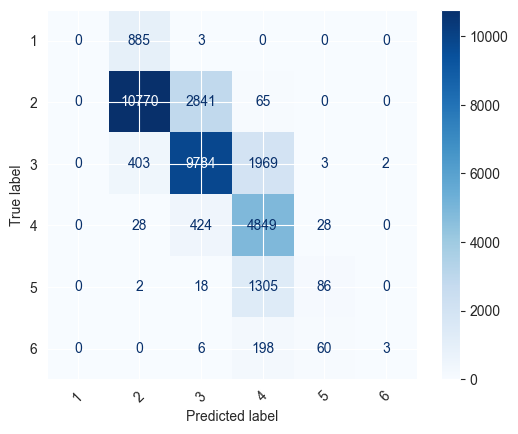

In [177]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = grouped_df_embed['true_label']
predicted_labels = grouped_df_embed['pred_label']

cm = confusion_matrix(true_labels, predicted_labels)
print(cm2)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
#print("Precision: ", precision_score(true_labels, predicted_labels))
#print("Recall: ", recall_score(true_labels, predicted_labels))
#print("F1: ", f1_score(true_labels, predicted_labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

In [165]:
grouped_df_embed['prediction'][0]

array([[1.01490195e-05, 9.99977350e-01, 1.22528591e-05, 1.61833691e-09,
        1.44837937e-08, 2.25087675e-07]], dtype=float32)

In [129]:
# [x for x in predictions if not isinstance(x, np.ndarray)]

[]

In [130]:
#len(predictions)

3366

In [121]:
#([np.argmax(x) for x in predictions[:4]], grouped_df_embed['most_abundant_charge_vector'][:4])

([1, 1, 2, 2],
 0    [1, 0, 0, 0, 0, 0]
 1    [0, 1, 0, 0, 0, 0]
 2    [0, 1, 0, 0, 0, 0]
 3    [0, 0, 1, 0, 0, 0]
 Name: most_abundant_charge_vector, dtype: object)

In [ ]:
grouped_df_embed.head(4)

In [113]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

cm2 = confusion_matrix(grouped_df_embed['most_abundant_charge_vector'][:168], np.array(predictions))
print(cm2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

#sn.heatmap(cm2, annot=True, cmap="crest")

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [34]:
inf_model = tf.keras.models.load_model('precursor_charge_prediction_conv2d_model/model_1_test.h5')

OSError: No file or directory found at precursor_charge_prediction_conv2d_model/model_1_test.h5

In [ ]:
# Make validation data
sample_df_inf = batches_parquet[file_list[1]][["precursor_charge", "precursor_intensity", "modified_sequence_vector"]].copy()

In [ ]:
# Split the data into train, validation, and test sets
sample_df_inf["precursor_intensity"] = sample_df_inf["precursor_intensity"].astype(int) # TODO or times 10 -> 0.1 = 1 .astype(int)
main_ds_inf = np.array(sample_df_inf[["precursor_intensity", "modified_sequence_vector"]]) # to list
main_ds_labels_inf = np.array(sample_df_inf['precursor_charge'])
max_len_inf = max(sample_df_inf.loc[:, 'modified_sequence_vector'].apply(len))  # Find the maximum length

charges = [2,3,4] # TODO SELECT CLASSES
num_classes = len(charges)

main_ds_labels_inf = np.array([one_hot_precursor(i, charges = charges) for i in main_ds_labels_inf])

In [ ]:
main_ds_inf_a, main_ds_inf_b = main_ds_inf[:, 0], main_ds_inf[:, 1:]

In [ ]:
main_ds_inf_a = main_ds_inf_a.reshape(main_ds_inf_a.shape[0], 1)
main_ds_inf_a = tf.convert_to_tensor(main_ds_inf_a, dtype=tf.int32)

main_ds_inf_b = [np.reshape(np.array(x[0]), (1, 50, 1)) for x in main_ds_inf_b]

In [ ]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(main_ds_inf_b[i], interpolation='nearest', cmap='seismic') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [ ]:
main_ds_inf_b[0].shape

In [ ]:
def batch_generator(X, Y, batch_size = 64):
    complete_batches = []
    x1, x2 = X
    indices = np.arange(len(x1))
    x1_array = []
    x2_array = []
    y_array = []
    for index, i in enumerate(x1):

        x1_array.append(i)
        x2_array.append(x2[index])
        y_array.append(Y[index])
        if len(x1_array)==batch_size:
            yield [x1_array, x2_array], y_array
            complete_batches.append([x1_array, x2_array], y_array)
            x1_array = []
            x2_array = []
            y_array = []
    return complete_batches


In [ ]:
train_generator = batch_generator([main_ds_inf_a, main_ds_inf_b], main_ds_labels_inf, batch_size = 32)
for batch in train_generator:
    intensities = tf.convert_to_tensor(batch[0][0], dtype=tf.int32)
    sequences = tf.convert_to_tensor(batch[0][1], dtype=tf.int32)
    labels = np.array(batch[1], dtype=np.float32)
    print(intensities)
    print(sequences)

    yhat = inf_model.predict([intensities, sequences], labels, epochs=10)
    #eval_prec.update_state(labels , yhat)
    #eval_rec.update_state(labels, yhat)
    #eval_acc.update_state(labels, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')

In [ ]:
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from matplotlib import cm
import tensorflow as tf
import numpy as np


for layerpos in range(len(model.layers)-1):
    try:
        image_size = general_image_size

        # Load pre-trained Keras model and the image to classify TODO VERIFY
        img_tensor = labeled
        img_tensor = np.expand_dims(img_tensor, axis=0)

        select_layer = model.layers[layerpos].name #was -4
        print(select_layer)
        conv_layer = model.get_layer(select_layer)
        heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

        heatmaps_generated = set()
        heatmap_list = []
        for pndex, value in enumerate(predictions[0]):
            with tf.GradientTape() as gtape:
                conv_output, predictions = heatmap_model(img_tensor)
                loss = predictions[0][pndex]
                grads = gtape.gradient(loss, conv_output)
                pooled_grads = K.mean(grads, axis=(0, 1, 2))

            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
            heatmap = np.maximum(heatmap, 0)
            max_heat = np.max(heatmap)
            if max_heat == 0:
                max_heat = 1e-10
            heatmap /= max_heat
            heatmaps_generated.add(heatmap.shape)
            heatmap_list.append(heatmap)
        print(heatmaps_generated)

        images_hm = []
        titles_hm = []
        predictions_hm = []

        for i in range(num_classes):
            # predictions
            prediction_value = (predictions[0][i])
            predictions_hm.append(prediction_value)

            # titles
            title = class_names[i]
            titles_hm.append(title)

            # images
            hm=np.squeeze(heatmap_list[i])

            current_img = (asarray(hm))
            sm = cm.ScalarMappable(cmap='seismic')
            sm.set_clim(current_img.min(), current_img.max())
            current_img = sm.to_rgba(current_img)
            current_img = current_img*255
            current_img = current_img.astype(np.uint8)
            current_img = cv2.cvtColor(current_img, cv2.COLOR_BGRA2BGR )
            images_hm.append(current_img)

        # plot them
        #print(len(images_hm))
        plot_image_grid(images_hm, titles_hm, predictions_hm, layername=select_layer)
    except:
        print("error", layerpos, end=" ")


# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [35]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [36]:
last_model = keras.models.load_model('precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5')

OSError: No file or directory found at precursor_charge_prediction_model_cce_alpha/cce_wo7_allSequences.h5

In [ ]:
batches_parquet.keys()

In [ ]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [37]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

NameError: name 'inference_df' is not defined

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [38]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

NameError: name 'inference_df' is not defined

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [39]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [40]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

NameError: name 'true_labels' is not defined

MCC

In [41]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

NameError: name 'true_labels' is not defined

Direct eval:

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [43]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

NameError: name 'test_ds' is not defined

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')